Trial Jupyter Notebook for combining Graph Isomorphism on Quantum Annealer code and ast to networkx graph conversion code


importing necessary stuff

In [27]:
import ast
import networkx as nx  
import sys
from graphviz import Digraph
import showast
import astpretty
import gsgmorph.pyqubo_form as gsgm_pqf
import pprint
import matplotlib.pyplot as plt  


#### Graph to Embed

In [28]:
graph_to_embed = nx.gnm_random_graph(50, 80)

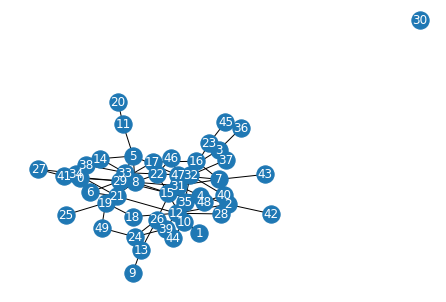

In [29]:
# Get the fixed position
# pos = nx.spring_layout(graph_to_embed, seed = 9999)

# Graph to Embed onto the target graph
nx.draw(graph_to_embed, with_labels = True, font_color = 'w')
plt.show()

#### Target Graph

In [30]:
target_graph = nx.gnm_random_graph(50, 80)

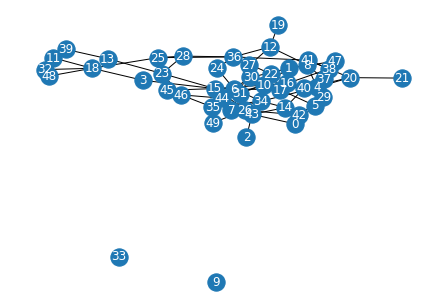

In [31]:
# Get the fixed position
# pos = nx.spring_layout(graph_to_embed, seed = 9999)

# Graph to Embed onto the target graph
nx.draw(target_graph, with_labels = True, font_color = 'w')
plt.show()

### Now starts the Quantum Annealing Part

In [32]:
# Get the PyQUBO expression and translation dictionary which allows us to 
# translate from the annealer results to the actual node mapping
pyqubo_exp, sample_translation_dict = gsgm_pqf.graph_isomorphism(graph_to_embed, target_graph)

In [33]:
import neal

# Initiate the annealer
sampler = neal.SimulatedAnnealingSampler()

# Convert the PyQUBO expression to a BQM that can be fed to the annealer
model = pyqubo_exp.compile()
bqm = model.to_bqm()

# Obtain smaples from annealing and choose the one with the lowest energy
# Keep in mind that there exist multiple satisfactory, low-energy solutions!
sampleset = sampler.sample(bqm, num_reads = 100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key = lambda x: x.energy)

In [34]:
# We can use the PyQUBO-translated sample and the sample tranclation dictionary
# from before to geenrate a dictionary that maps nodes from the graph to be embedded
# and the target graph
mapping = gsgm_pqf.translate_sample(best_sample, sample_translation_dict)

In [35]:
mapping

{9: 5,
 47: 17,
 46: 37,
 45: 18,
 43: 29,
 42: 27,
 41: 46,
 40: 30,
 38: 28,
 48: 1,
 37: 45,
 49: 21,
 36: 3,
 33: 25,
 10: 43,
 2: 31,
 22: 8,
 27: 35,
 35: 10,
 44: 14,
 25: 9,
 8: 12,
 23: 11,
 21: 38,
 28: 6,
 14: 36,
 20: 13,
 6: 16,
 18: 48,
 13: 4,
 11: 39,
 39: 40,
 17: 42,
 30: 44,
 3: 15,
 31: 22,
 1: 0,
 34: 41,
 16: 26,
 0: 23,
 24: 20}

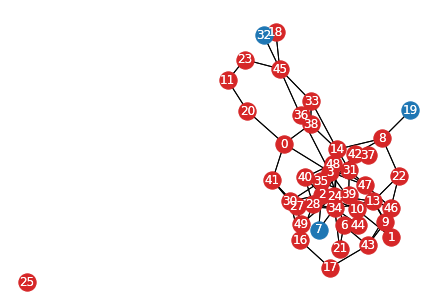

In [36]:
# We can use NetworkX o visualize the subgraph and how it fits onto the target graph

# Invert the mapping so it is from the target graph to the graph_to_embed nodes
inv_mapping = {v: k for k, v in mapping.items()}

# relabel those nodes in the target graph wit hthe node labels from the graph to embed
updated_nodes = nx.relabel_nodes(target_graph, inv_mapping, copy = True)

# Get the same fixed position used before
pos = nx.spring_layout(updated_nodes, seed = 9999)

# Highlight the nodes that have been relabeled
nx.draw(updated_nodes, 
        pos, 
        with_labels = True, 
        font_color = 'w', 
        nodelist = [key for key in mapping.keys()],
        node_color = "tab:red")
# Difference between the two lists
nx.draw(updated_nodes, 
        pos, 
        with_labels = True, 
        font_color = 'w', 
        nodelist = list(set(updated_nodes.nodes()) - set(mapping.keys())), 
        node_color = "tab:blue")